# This Notebook contains the code to create (or load) the data and plots for Figures 4.6 and 4.8

Start by importing the necessary modules

In [1]:
# Standard modules
import numpy as np
import scipy
from matplotlib import pyplot as plt

# Local packages
from simulator_program.custom_noise_models import standard_times
from simulator_program import data_analysis_tools

Adding custom device equivalences


/home/alexion/anaconda3/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


## Part 1: Creating Figure 4.6

In [2]:
# Simulation parameters
n_cycles = 15
n_shots = 1024*8*3

# Noise parameters
T1 = 40e3
T2 = 60e3

In [3]:
# Run simulations (TAKES UP TO AN HOUR TO RUN, DATA CAN BE LOADED BELOW INSTEAD)
fid_L_s, P_L_s, time_s = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots, 
    gate_times=standard_times, T1=T1, T2=T2, encoding=False, project=True)
print('Standard run done')
fid_L_f, P_L_f, time_f = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots,
    gate_times={'feedback': 5000}, T1=T1, T2=T2, encoding=False, project=True)
print('Extra feedback time done')
fid_L_d, P_L_d, time_d = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots,
    gate_times={'delay': 5000}, T1=T1, T2=T2, encoding=False, project=True)
print('Added delay time time done')

Standard run done
Extra feedback time done
Added delay time time done


In [ ]:
# Reformat as np arrays
fid_L_standard = np.array(fid_L_s)
fid_L_feedback = np.array(fid_L_f)
fid_L_delay = np.array(fid_L_d)
P_L_standard = np.array(P_L_s)
P_L_feedback = np.array(P_L_f)
P_L_delay = np.array(P_L_d)

# Generate x-values from times dict
t_standard = np.array([time_s['dm_'+str(i)] for i in range(n_cycles+1)])
t_feedback = np.array([time_f['dm_'+str(i)] for i in range(n_cycles+1)])
t_delay    = np.array([time_d['dm_'+str(i)] for i in range(n_cycles+1)])



In [27]:
# SAVE DATA 
# Note: The standard run can be generated from the file active_qec.ipynb.
#       Therefore we do not save it from this file

# 5mus feedback run
with open('data/feedback_5mus_data.npy', 'wb') as f:
    np.save(f, (fid_L_feedback, P_L_feedback, t_feedback))

# 5mus delay run
with open('data/delay_5mus_data.npy', 'wb') as f:
    np.save(f, (fid_L_delay, P_L_delay, t_delay))

In [3]:
# LOAD DATA
# Standard run (Note that not all the data is used)
with open('data/base_qec_data.npy', 'rb') as f:
    fid_L_standard, P_L_standard, t_standard = np.load(f)
with open('data/feedback_5mus_data.npy', 'rb') as f:
    fid_L_feedback, P_L_feedback, t_feedback = np.load(f)
with open('data/delay_5mus_data.npy', 'rb') as f:
    fid_L_delay, P_L_delay, t_delay = np.load(f)

In [4]:
# Calculate fidelity by F = F_L * P_L
fid_standard = np.array(fid_L_standard)
fid_standard[1:] = fid_standard[1:]*np.mean(P_L_standard)
fid_feedback = np.array(fid_L_feedback)
fid_feedback[1:] = fid_feedback[1:]*np.mean(P_L_feedback[1:])
fid_delay = np.array(fid_L_delay)
fid_delay[1:] = fid_delay[1:]*np.mean(P_L_delay[1:])

In [5]:
# Perform curve fitting
def monoExp(t, T, c, A):
    return (A-c) * np.exp(-t/T) + c
p0 = (40e3, 0, 0.9)  # start with values near those we expect
pars_s, cov_s = scipy.optimize.curve_fit(
    monoExp, t_standard[1:], fid_standard[1:], p0)
pars_f, cov_f = scipy.optimize.curve_fit(
    monoExp, t_feedback[1:], fid_feedback[1:], p0)
pars_d, cov_d = scipy.optimize.curve_fit(
    monoExp, t_delay[1:], fid_delay[1:], p0)

<ipython-input-7-53228306b5a4>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["0", "0", "20", "40", "60", "80", "100", "120", "140"])


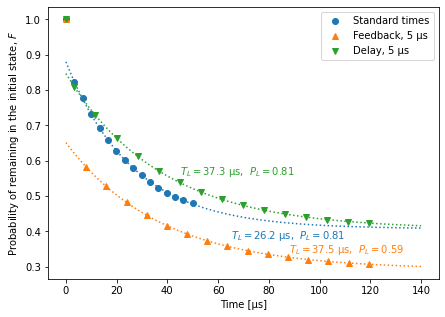

In [7]:
# %% Plotting
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot data points
ax.plot(t_standard, fid_standard, 'o', color='C0', label='Standard times')
ax.plot(t_feedback, fid_feedback, '^', color='C1', label='Feedback, 5 μs')
ax.plot(t_delay, fid_delay, 'v', color='C2', label='Delay, 5 μs')

# Perform curve fits for plotting
time_list = [t_standard, t_feedback, t_delay]
fid_list = [fid_standard, fid_feedback, fid_delay]
P_list = [np.mean(P_L_standard[1:]), np.mean(
    P_L_feedback[1:]), np.mean(P_L_delay[1:])]
color_list = ['C0', 'C1', 'C2']
lifetimes = []
errs = []
t = np.linspace(0, 140e3, 100)
for i in range(len(time_list)):
    p0 = (40e3, 0, 0.9)  # start with values near those we expect
    x = time_list[i]
    y = fid_list[i]
    pars, cov = scipy.optimize.curve_fit(monoExp, x[1:], y[1:], p0)
    T, c, A = pars
    lifetimes.append(T)
    errs.append(np.sqrt(cov[0][0]))
    ax.plot(t, monoExp(t, *pars), ':', color=color_list[i])
ax.text(65000, 0.38,
        rf'$T_L ={lifetimes[0]/1000:.1f}$ μs,  $P_L={P_list[0]:.2f}$', color='C0')
ax.text(88000, 0.34,
        rf'$T_L ={lifetimes[1]/1000:.1f}$ μs,  $P_L={P_list[1]:.2f}$', color='C1')
ax.text(45000, 0.56,
        rf'$T_L ={lifetimes[2]/1000:.1f}$ μs,  $P_L={P_list[2]:.2f}$', color='C2')
ax.set_xticklabels(["0", "0", "20", "40", "60", "80", "100", "120", "140"])

ax.set_xlabel('Time [μs]')
ax.set_ylabel(r'Probability of remaining in the initial state, $F$')
ax.legend()

## Part 2: Creating Figure 4.8
The procedure is identical to part 1. Here we instead compare the fidelity and
lifetime for three setups: The hexagonal layout, double diamond layout and the
pipelined hexagonal layout. 

In [ ]:
# Simulation parameters
n_cycles = 15
n_shots = 1024*8*3

# Noise parameters
T1 = 40e3
T2 = 60e3

In [ ]:
# Generate data
# With the number of cycles and shots used, each simulation takes approximately
# 30 minutes, resulting in a total of 3 hours for all six. Instead, data can
# be loaded further down

# QEC, no delay, hexagonal layout (Identical to the standard run in part 1)
fid_L_hex, P_L_hex, time_hex = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots,
    gate_times=standard_times, T1=T1, T2=T2, encoding=False, transpile=True, project=True)

# QEC, no delay, square layout
fid_L_DD, P_L_DD, time_DD = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots,
    gate_times=standard_times, T1=T1, T2=T2, encoding=False, transpile=False, project=True, 
    device='double_diamond')

# QEC, no delay, pipelined (hexagonal layout)
fid_L_pipe, P_L_pipe, time_pipe = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots,
    gate_times=standard_times, T1=T1, T2=T2, encoding=False, transpile=False, project=True, 
    pipeline=True, include_barriers=False)

# QEC, with delay, hexagonal layout (Identical to the delay run in part 1)
fid_L_hex_d, P_L_hex_d, time_hex_d = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots,
    gate_times={'delay': 5000}, T1=T1, T2=T2, encoding=False, transpile=True, project=True)

# QEC, with delay, square layout
fid_L_DD_d, P_L_DD_d, time_DD_d = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots,
    gate_times={'delay': 5000}, T1=T1, T2=T2, encoding=False, transpile=False, project=True, 
    device='double_diamond')

# QEC, with delay, pipelined (hexagonal layout)
fid_L_pipe_d, P_L_pipe_d, time_pipe_d = data_analysis_tools.fidelity_from_scratch(n_cycles, n_shots,
    gate_times={'delay': 4000}, T1=T1, T2=T2, encoding=False, transpile=False, project=True, 
    pipeline=True, include_barriers=False)


In [ ]:
# Reformat outputs as np arrays
fid_L_hex = np.array(fid_L_hex)
fid_L_DD = np.array(fid_L_DD)
fid_L_pipe = np.array(fid_L_pipe)
fid_L_hex_d = np.array(fid_L_hex_d)
fid_L_DD_d = np.array(fid_L_DD_d)
fid_L_pipe_d = np.array(fid_L_pipe_d)
P_L_hex = np.array(P_L_hex)
P_L_DD = np.array(P_L_DD)
P_L_pipe = np.array(P_L_pipe)
P_L_hex_d = np.array(P_L_hex_d)
P_L_DD_d = np.array(P_L_DD_d)
P_L_pipe_d = np.array(P_L_pipe_d)

# Generate x-values
t_hex = np.array([time_hex['dm_'+str(i)] for i in range(n_cycles+1)])
t_DD = np.array([time_DD['dm_'+str(i)] for i in range(n_cycles+1)])
t_pipe = np.array([time_pipe['dm_'+str(i)] for i in range(n_cycles+1)])
t_hex_d = np.array([time_hex_d['dm_'+str(i)] for i in range(n_cycles+1)])
t_DD_d = np.array([time_DD_d['dm_'+str(i)] for i in range(n_cycles+1)])
t_pipe_d = np.array([time_pipe_d['dm_'+str(i)] for i in range(n_cycles+1)])

In [10]:
# SAVE DATA
# Note: The standard run can be generated from the file active_qec.ipynb.
#       Therefore we do not save it from this file.
#       The hexagonal 5mus delay run can also be generated in part 1, and is saved there

# Double diamond run
with open('data/QEC_square_standard_times.npy', 'wb') as f:
    np.save(f, (fid_L_DD, P_L_DD, t_DD))

# Pipeline run
with open('data/QEC_pipeline_standard_times.npy', 'wb') as f:
    np.save(f, (fid_L_pipe, P_L_pipe, t_pipe))

# Double diamond with delay
with open('data/QEC_square_5mus_delay.npy', 'wb') as f:
    np.save(f, (fid_L_DD_d, P_L_DD_d, t_DD_d))

# Pipeline with delay
with open('data/QEC_pipeline_5mus_delay.npy', 'wb') as f:
    np.save(f, (fid_L_pipe_d, P_L_pipe_d, t_pipe_d))

In [11]:
# LOAD DATA
# Standard run 
with open('data/base_qec_data.npy', 'rb') as f:
    fid_L_hex, P_L_hex, t_hex = np.load(f)

# Double diamond run
with open('data/QEC_square_standard_times.npy', 'rb') as f:
    fid_L_DD, P_L_DD, t_DD = np.load(f)

# Pipeline run
with open('data/QEC_pipeline_standard_times.npy', 'rb') as f:
    fid_L_pipe, P_L_pipe, t_pipe = np.load(f)

# Standard run 
with open('data/delay_5mus_data.npy', 'rb') as f:
    fid_L_hex_d, P_L_hex_d, t_hex_d = np.load(f)

# Double diamond run
with open('data/QEC_square_5mus_delay.npy', 'rb') as f:
    fid_L_DD_d, P_L_DD_d, t_DD_d = np.load(f)

# Pipeline run
with open('data/QEC_pipeline_5mus_delay.npy', 'rb') as f:
    fid_L_pipe_d, P_L_pipe_d, t_pipe_d = np.load(f)

In [13]:
# Calculate fidelity by F = F_L * P_L
fid_hex = np.ones(n_cycles+1)
fid_DD = np.ones(n_cycles+1)
fid_pipe = np.ones(n_cycles+1)
fid_hex_d = np.ones(n_cycles+1)
fid_DD_d = np.ones(n_cycles+1)
fid_pipe_d = np.ones(n_cycles+1)
fid_hex[1:] = fid_L_hex[1:]*np.mean(P_L_hex[1:])
fid_DD[1:] = fid_L_DD[1:]*np.mean(P_L_DD[1:])
fid_pipe[1:] = fid_L_pipe[1:]*np.mean(P_L_pipe[1:])
fid_hex_d[1:] = fid_L_hex_d[1:]*np.mean(P_L_hex_d[1:])
fid_DD_d[1:] = fid_L_DD_d[1:]*np.mean(P_L_DD_d[1:])
fid_pipe_d[1:] = fid_L_pipe_d[1:]*np.mean(P_L_pipe_d[1:])

In [14]:
# Perform curve fits
p0 = (40e3, 0, 0.9)  # start with values near those we expect
pars_hex, cov_hex = scipy.optimize.curve_fit(
    monoExp, t_hex[1:], fid_L_hex[1:], p0)
pars_DD, cov_DD = scipy.optimize.curve_fit(monoExp, t_DD[1:], fid_L_DD[1:], p0)
pars_pipe, cov_pipe = scipy.optimize.curve_fit(
    monoExp, t_pipe[1:], fid_L_pipe[1:], p0)
pars_hex_d, cov_hex_d = scipy.optimize.curve_fit(
    monoExp, t_hex_d[1:], fid_L_hex_d[1:], p0)
pars_DD_d, cov_DD_d = scipy.optimize.curve_fit(
    monoExp, t_DD_d[1:], fid_L_DD_d[1:], p0)
pars_pipe_d, cov_pipe_d = scipy.optimize.curve_fit(
    monoExp, t_pipe_d[1:], fid_L_pipe_d[1:], p0)

<ipython-input-19-f9b1ba056f45>:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["0", "0", "20", "40", "60", "80", "100", "120", "140"])


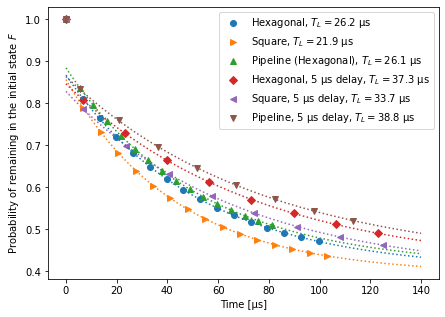

In [19]:
# %% Plot figures
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# No delay plots (Commented out in Figure 4.8)
ax.plot(t_hex, fid_hex, 'o', color='C0',
       label=rf'Hexagonal, $T_L ={pars_hex[0]/1000:.1f}$ μs')
ax.plot(t_DD, fid_DD, '>', color='C1',
       label=rf'Square, $T_L ={pars_DD[0]/1000:.1f}$ μs')
ax.plot(t_pipe, fid_pipe, '^', color='C2',
       label=rf'Pipeline (Hexagonal), $T_L ={pars_pipe[0]/1000:.1f}$ μs')

# With-delay plots
ax.plot(t_hex_d[:9], fid_hex_d[:9], 'D', color='C3',
        label=rf'Hexagonal, 5 μs delay, $T_L ={pars_hex_d[0]/1000:.1f}$ μs')
ax.plot(t_DD_d[:9], fid_DD_d[:9], '<', color='C4',
        label=rf'Square, 5 μs delay, $T_L ={pars_DD_d[0]/1000:.1f}$ μs')
ax.plot(t_pipe_d[:9], fid_pipe_d[:9], 'v', color='C5',
        label=rf'Pipeline, 5 μs delay, $T_L ={pars_pipe_d[0]/1000:.1f}$ μs')

# Plot fitted curves
t = np.linspace(0, 70e3, 100)
ax.plot(t, monoExp(t, *pars_hex)*np.mean(P_L_hex[1:]), ':', color='C0')
ax.plot(t, monoExp(t, *pars_DD)*np.mean(P_L_DD[1:]), ':', color='C1',zorder=-5)
ax.plot(t, monoExp(t, *pars_pipe)*np.mean(P_L_pipe[1:]), ':', color='C2',zorder=-5)
ax.plot(t, monoExp(t, *pars_hex_d) *
        np.mean(P_L_hex_d[1:]), ':', color='C3', zorder=-5)
ax.plot(t, monoExp(t, *pars_DD_d) *
        np.mean(P_L_DD_d[1:]), ':', color='C4', zorder=-5)
ax.plot(t, monoExp(t, *pars_pipe_d) *
        np.mean(P_L_pipe_d[1:]), ':', color='C5', zorder=-5)

# Axes settings
ax.set_xticklabels(["0", "0", "20", "40", "60", "80", "100", "120", "140"])
ax.set_xlabel('Time [μs]')
ax.set_ylabel(r'Probability of remaining in the initial state $F$')
ax.legend()